In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from shifterator import shifts
import re
import itertools
import collections
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np
import scipy.stats as stats
from scipy.stats import entropy

In [2]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

# Data Exploration

In [3]:
rfc_df.head()

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z


In [4]:
comment_df = comment_df.rename(columns={'user': 'user_name'})
comment_df.head()

,date,id,parent_id,section,text,user_name,project,rfc_id,page_title,page_id,language
0,2020-10-06T13:22:00Z,0,0,NaN,There is a disagreement regarding the defintio...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
1,2020-10-07T06:22:00Z,1,0,==Summary of discussion==,The main contention is whether to include a si...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
2,2020-10-06T16:03:00Z,2,1,==Summary of discussion==,"It is not our purpose to define a term, but to...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en
3,2020-10-06T16:27:00Z,3,2,==Summary of discussion==,Thanks for your response. All the editors cont...,Robynthehode,wikipedia,0,Talk:Skyscraper,29488,en
4,2020-10-06T18:15:00Z,4,3,==Summary of discussion==,"What, all 32,000+ characters (excluding sigs a...",Redrose64,wikipedia,0,Talk:Skyscraper,29488,en


In [5]:
users_df.head()

,user_id,user_name,user_real_name,seconds_between_regdate_and_first_edit_date,isDeleted,user_registration,editcount,permissions
0,910196.0,Robynthehode,,1715797.0,False,2009-02-15T15:47:20,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
1,187002.0,Redrose64,,791.0,False,2009-05-05T12:46:21,"{'mediawikiwiki': 22, 'metawiki': 1981, 'wikid...","{'mediawikiwiki': 'user', 'metawiki': 'autopat..."
2,2641273.0,SportingFlyer,,300.0,False,2005-12-29T05:11:26,"{'mediawikiwiki': 0, 'metawiki': 1, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
3,427425.0,Jirka.h23,,1535546.0,False,2009-07-23T14:11:10,"{'mediawikiwiki': 0, 'metawiki': 0, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."
4,958820.0,MelbourneStar,,2265847.0,False,2010-11-21T01:57:52,"{'mediawikiwiki': 1, 'metawiki': 5, 'wikidataw...","{'mediawikiwiki': 'user', 'metawiki': 'user', ..."


In [6]:
print(f'There are {len(rfc_df)} individual rfc')
print(f'There are {len(comment_df)} individual commments')
print(f'there are {len(users_df)} individual users')

There are 2302 individual rfc
There are 92254 individual commments
there are 8395 individual users


In [7]:
print(len(rfc_df[rfc_df['project'] == 'wikipedia']))
print(len(rfc_df[rfc_df['project'] == 'wikidata']))
print(len(rfc_df[rfc_df['project'] == 'meta.wikimedia']))

1552
140
610


In [8]:
print(f"{len(users_df[users_df['editcount'].isna()])} users do not exist in database anymore " )

588 users do not exist in database anymore 


Sum all wikipedia edit count to one value

In [9]:
# define list of wikis to include
wikis_to_include = ['enwiki','eswiki','frwiki','dewiki','zhwiki','jawiki','plwiki','ruwiki','itwiki','nlwiki','ptwiki']

# create new column with sum of edit counts for desired wikis
def sum_edit_counts(edit_count_dict, wikis_to_include):
    try:
        if edit_count_dict:
            edit_count_dict['wikipedia_project_sum'] = sum(edit_count_dict[wiki] for wiki in wikis_to_include)
            return edit_count_dict
        else:
            return edit_count_dict
    except KeyError:
        print(edit_count_dic)

users_df['editcount'] = users_df['editcount'].apply(lambda x: sum_edit_counts(x, wikis_to_include))

In [10]:
# drop rows with any NA values
users_df = users_df.dropna()
# projects to calculate median edit count for
projects = ['metawiki', 'wikidatawiki', 'wikipedia_project_sum']

# create list of edit counts for each project
edit_counts = [[d.get(p, 0) for d in users_df['editcount']] for p in projects]

# calculate median edit count for each project
median_edit_counts = [pd.Series(ec).median() for ec in edit_counts]
for i, p in enumerate(projects):
    print(f"The median edit count for {p} is {median_edit_counts[i]}")

The median edit count for metawiki is 9.0
The median edit count for wikidatawiki is 46.0
The median edit count for wikipedia_project_sum is 9415.5


In [11]:
# convert registration_date to datetime object
users_df['user_registration'] = pd.to_datetime(users_df['user_registration'])

# calculate account age
users_df['account_age'] = (datetime.now() - users_df['user_registration']).dt.days

median_account_age = users_df['account_age'].median()

print(f"The median account age is {median_account_age} days")

The median account age is 4931.0 days


## Participants

# Participants per RfC

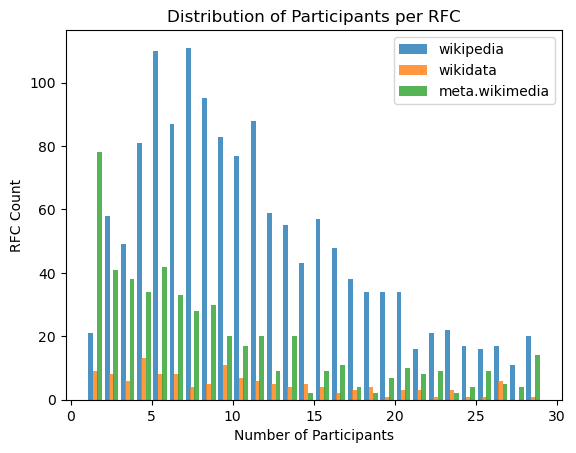

In [12]:
import seaborn as sns
# merge comment dataframe with RFC dataframe
merged_df = pd.merge(comment_df, rfc_df, on='rfc_id')
grouped = merged_df.groupby(['project_x', 'rfc_id'])['user_name'].nunique().reset_index(name='participants')

pivoted = grouped.pivot(index='rfc_id', columns='project_x', values='participants').fillna(0)

plt.hist([pivoted['wikipedia'], pivoted['wikidata'], pivoted['meta.wikimedia']], bins=range(1, 30), stacked=False, label=['wikipedia', 'wikidata', 'meta.wikimedia'],width=0.3,alpha = 0.8, align='mid')
plt.legend()
# Add a title to the plot
plt.title('Distribution of Participants per RFC')

# Add a label to the x-axis
plt.xlabel('Number of Participants')

# Add a label to the y-axis
plt.ylabel('RFC Count')
plt.show()

# Roles count per Project

In [13]:
# Define the order of roles
roles = ['sysop', 'bureaucrat', 'user']

# Define a function to map the values in the dictionary to the roles
def map_permissions_to_role(permissions_dic):
    for role in roles:
        if role in permissions_dic.values():
            return role
    return None

# Apply the function to the permissions_dic column to create the new role column
users_df['role'] = users_df['permissions'].apply(map_permissions_to_role)

In [14]:
users_df.groupby(["role"]).count()["user_id"]

role
bureaucrat      56
sysop          290
user          6822
Name: user_id, dtype: int64

# Diversity of RfC groups

In [15]:
#Add total_editcount to user
# List of keys to sum editcounts for
keys_to_sum = ['wikipedia_project_sum','wikidatawiki','metawiki']

# Define a function to extract the desired editcounts from a dictionary
def extract_editcounts(editcount_dict, keys):
    return sum(editcount_dict.get(key) for key in keys)

# Apply the function to each row of the dataframe and sum up the results
users_df['total_editcount'] = users_df['editcount'].apply(extract_editcounts, args=(keys_to_sum,))


In [16]:
merged_df = comment_df.merge(users_df, on='user_name')
# group by rfc
grouped = merged_df.groupby('rfc_id')

# calculate total number of users per rfc
total_users = grouped['user_name'].count()

# calculate frequency of each unique combination of role, account age, and edit_count per rfc
freq = grouped.apply(lambda x: x.groupby(['role', 'account_age', 'total_editcount'])['user_name'].count())

# calculate probability of each unique combination of role, account age, and edit_count per rfc
prob = freq / total_users

# calculate entropy for each rfc
entropy = - (prob * np.log2(prob)).groupby('rfc_id').sum()
entropy.name = 'entropy'

print(entropy)

rfc_id
0       1.891909
1       0.918296
2       2.848941
3       2.848941
4       3.143759
          ...   
2297    3.844969
2298    3.546594
2299    2.251629
2300    2.865749
2301    4.610900
Name: entropy, Length: 2266, dtype: float64


In [17]:
# merge the entropy values with the original dataframe
merged_df = pd.merge(rfc_df, entropy, on='rfc_id')

# calculate the average entropy per column based on the 'project' column
avg_entropy = merged_df.groupby('project')['entropy'].mean()

print(avg_entropy)

project
meta.wikimedia    2.535758
wikidata          2.627441
wikipedia         2.832819
Name: entropy, dtype: float64


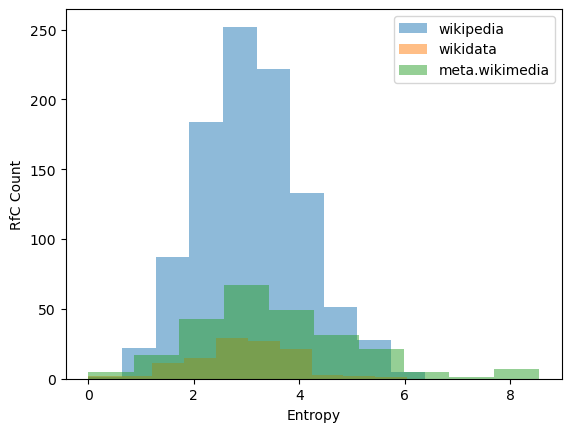

In [18]:
grouped = merged_df.groupby(['project', 'entropy']).size().reset_index(name='count')

# Get a list of all projects
projects = merged_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['entropy'], bins=10, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Entropy')
plt.ylabel('RfC Count')
plt.legend()

# Show the plot
plt.show()

In [19]:
from scipy.stats import ttest_ind
# create three separate dataframes for each project
project_1_df = merged_df[merged_df['project'] == 'wikipedia']
project_2_df = merged_df[merged_df['project'] == 'wikidata']
project_3_df = merged_df[merged_df['project'] == 'meta.wikimedia']

# perform pairwise t-tests
t_12, p_12 = ttest_ind(project_1_df['entropy'], project_2_df['entropy'])
t_13, p_13 = ttest_ind(project_1_df['entropy'], project_3_df['entropy'])
t_23, p_23 = ttest_ind(project_2_df['entropy'], project_3_df['entropy'])

# print results
print("Wikipedia vs. Wikidata: t-value = ", t_12, ", p-value = ", p_12)
print("Wikipedia vs. Meta: t-value = ", t_13, ", p-value = ", p_13)
print("Wikidata vs. Meta: t-value = ", t_23, ", p-value = ", p_23)

Wikipedia vs. Wikidata: t-value =  2.105331865302607 , p-value =  0.03541019067703101
Wikipedia vs. Meta: t-value =  4.722517284388692 , p-value =  2.481587181630887e-06
Wikidata vs. Meta: t-value =  0.6003813093388569 , p-value =  0.5484415901827079


In [20]:
from scipy.stats import f_oneway
# group by `project` column
grouped_df = merged_df.groupby('project')

# perform ANOVA test
f_value, p_value = f_oneway(*[grouped_df.get_group(x)['entropy'] for x in grouped_df.groups])

# print results
print("F-value: ", f_value)
print("P-value: ", p_value)

F-value:  11.85842400474017
P-value:  7.529250574187927e-06


In [21]:
merged_df = comment_df.merge(users_df, on='user_name')
# group the dataframe by 'rfc_id'
grouped = merged_df.groupby('rfc_id')

# define the function to calculate Hill number-based diversity measures for each group using Hill–Shannon diversity
def hill_diversity(group):
    '''
    Refer to: 
    https://onlinelibrary.wiley.com/doi/full/10.1111/oik.07202#:~:text=Hill%20diversity%20comprises%20a%20spectrum%20of%20diversity%20metrics,the%20same%20scale%20and%20in%20units%20of%20species.
    '''
    # calculate the proportions of each user role, mean account age, and mean edit count in the group
    role_proportions = group['role'].value_counts(normalize=True)
    age_proportions = group['account_age'] / group['account_age'].sum()
    edit_proportions = group['total_editcount'] / group['total_editcount'].sum()

    # add a small value to the proportions to prevent division by zero
    epsilon = 1e-10
    role_proportions = role_proportions + epsilon
    age_proportions = age_proportions + epsilon
    edit_proportions = edit_proportions + epsilon
      
    

    # calculate the Hill number-based diversity measures for the user roles, account age, and edit count
    role_diversity = np.power(np.e, -(np.sum(np.multiply(role_proportions, np.log(role_proportions)))))
    age_diversity = np.power(np.e, -(np.sum(np.multiply(age_proportions, np.log(age_proportions)))))
    edit_diversity = np.power(np.e, -(np.sum(np.multiply(edit_proportions, np.log(edit_proportions)))))
    
    # return a dictionary with the diversity measures for user roles, account age, and edit count
    return {'role_diversity': role_diversity, 'age_diversity': age_diversity, 'edit_diversity': edit_diversity}

# apply the function to each group in the grouped dataframe for each q value
hill_diversity_df = pd.DataFrame(grouped.apply(hill_diversity))

In [22]:
print(hill_diversity_df)

                                                        0
rfc_id                                                   
0       {'role_diversity': 0.9999999999, 'age_diversit...
1       {'role_diversity': 0.9999999999, 'age_diversit...
2       {'role_diversity': 0.9999999999, 'age_diversit...
3       {'role_diversity': 0.9999999999, 'age_diversit...
4       {'role_diversity': 0.9999999999, 'age_diversit...
...                                                   ...
2297    {'role_diversity': 1.252445431876781, 'age_div...
2298    {'role_diversity': 1.8538077548794378, 'age_di...
2299    {'role_diversity': 1.8898815747485862, 'age_di...
2300    {'role_diversity': 0.9999999999, 'age_diversit...
2301    {'role_diversity': 1.2555669095125173, 'age_di...

[2266 rows x 1 columns]


In [23]:
rfc_df = rfc_df.merge(hill_diversity_df, on='rfc_id')

In [24]:
# use apply and lambda to extract dictionary values to columns
rfc_df[['role_diversity', 'age_diversity', 'edit_diversity']] = rfc_df[0].apply(lambda x: pd.Series({'role_diversity': x['role_diversity'], 'age_diversity': x['age_diversity'], 'edit_diversity': x['edit_diversity']}))

# drop the original dictionary column
rfc_df = rfc_df.drop(0, axis=1)

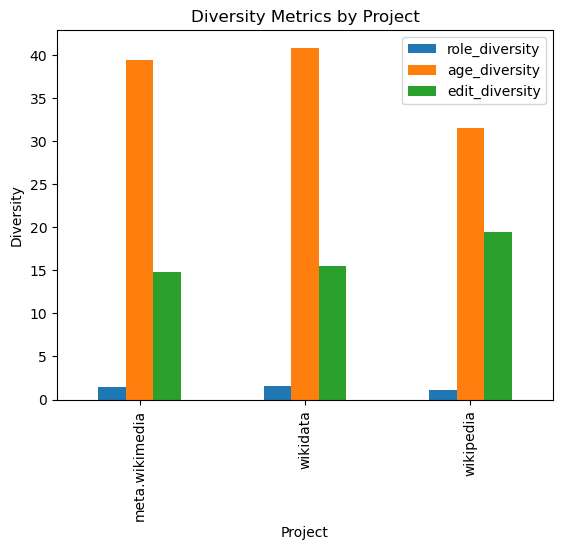

In [25]:
# group the DataFrame by project and calculate the mean of each diversity metric
filtered_df = rfc_df.filter(['project', 'role_diversity', 'age_diversity', 'edit_diversity'])
grouped_df = filtered_df.groupby('project').mean()

# plot the diversity metrics for each project
grouped_df.plot(kind='bar')
plt.title('Diversity Metrics by Project')
plt.xlabel('Project')
plt.ylabel('Diversity')
plt.show()

## Content

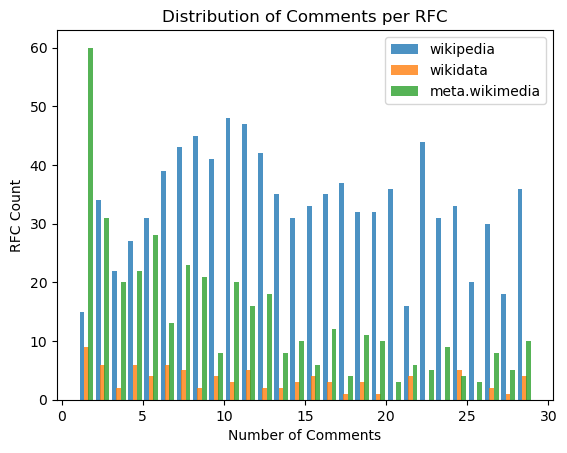

In [26]:
# merge comment dataframe with RFC dataframe
grouped = comment_df.groupby(['project', 'rfc_id'])['text'].count().reset_index(name='comments')

pivoted = grouped.pivot(index='rfc_id', columns='project', values='comments').fillna(0)

plt.hist([pivoted['wikipedia'], pivoted['wikidata'], pivoted['meta.wikimedia']], bins=range(1, 30),alpha=0.8, stacked=False, label=['wikipedia', 'wikidata', 'meta.wikimedia'],width=0.3)
plt.legend()
# Add a title to the plot
plt.title('Distribution of Comments per RFC')

# Add a label to the x-axis
plt.xlabel('Number of Comments')

# Add a label to the y-axis
plt.ylabel('RFC Count')
plt.show()

In [27]:
'''
# Group the DataFrame by project, RFC, and user, count the number of comments, and reset the index
grouped = comment_df.groupby(['project', 'rfc_id', 'user_name'])['text'].unique().reset_index(name='comments')


# Pivot the DataFrame so that each project is a column and each RFC is a row
pivoted = grouped.pivot(index='rfc_id', columns='project', values='comments').fillna(0)

# Create a horizontal stacked histogram with the number of comments per RFC per user on the x-axis
plt.hist([pivoted['Project A'], pivoted['Project B'], pivoted['Project C']], bins=range(1, 11), stacked=True, label=['Project A', 'Project B', 'Project C'], orientation='horizontal')

# Set the y-ticks to show the RFC index
plt.yticks(range(1, 11))

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Add a legend to the plot
plt.legend()

# Add a title to the plot
plt.title('Distribution of Comments per RFC per User for Three Projects')

# Add a label to the x-axis
plt.xlabel('Average Comments per Unique Comment')

# Add a label to the y-axis
plt.ylabel('RFC Index')

# Display the plot
plt.show()
'''

"\n# Group the DataFrame by project, RFC, and user, count the number of comments, and reset the index\ngrouped = comment_df.groupby(['project', 'rfc_id', 'user_name'])['text'].unique().reset_index(name='comments')\n\n\n# Pivot the DataFrame so that each project is a column and each RFC is a row\npivoted = grouped.pivot(index='rfc_id', columns='project', values='comments').fillna(0)\n\n# Create a horizontal stacked histogram with the number of comments per RFC per user on the x-axis\nplt.hist([pivoted['Project A'], pivoted['Project B'], pivoted['Project C']], bins=range(1, 11), stacked=True, label=['Project A', 'Project B', 'Project C'], orientation='horizontal')\n\n# Set the y-ticks to show the RFC index\nplt.yticks(range(1, 11))\n\n# Rotate the x-axis labels\nplt.xticks(rotation=90)\n\n# Add a legend to the plot\nplt.legend()\n\n# Add a title to the plot\nplt.title('Distribution of Comments per RFC per User for Three Projects')\n\n# Add a label to the x-axis\nplt.xlabel('Average Comme

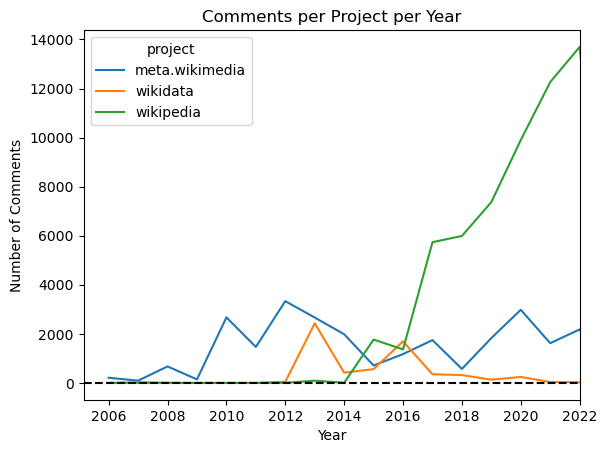

In [28]:
# convert date column to datetime format2
comment_df['date'] = pd.to_datetime(comment_df['date'])

# extract the year from date column and create a new column
comment_df['year'] = comment_df['date'].dt.year

# Group the dataframe by project and year, and count the number of comments
counts = comment_df.groupby(["project", "year"]).size().reset_index(name="count")

# Pivot the counts dataframe to have projects as columns and years as rows
pivoted = counts.pivot(index="year", columns="project", values="count")

# Fill missing values with 0
pivoted = pivoted.fillna(0)


# Plot the pivoted dataframe as a line chart
ax = pivoted.plot(kind="line")
# Add a horizontal line at y=0
ax.axhline(y=0, color="black", linestyle="--")
# Set the x axis limit to 2023
ax.set_xlim(left=None, right=2022)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Comments")
# Add a title to the plot
plt.title('Comments per Project per Year')
plt.show()

## Deliberation

In [29]:
deliberation_df = pd.read_csv('../data/final_rfc_statements.csv')
deliberation_df = deliberation_df.drop('question', axis=1)
rfc_df = pd.read_csv('../data/rfc.csv')

In [30]:
metric_list = [
    'has_question', 'response', 'advocacy', 'public_interest',
    'has_respect', 'explanation', 'causal_reasoning', 'narrative',
    'counterarguments', 'constructive_proposal'
]

In [31]:
# Identify the column you want to exclude
excluded_column = "disrespect"

# Calculate the row sum of the metrics and subtract the disrespect column
deliberation_df["DQI-Value"] = deliberation_df[metric_list].sum(axis=1) - deliberation_df['disrespect']

In [32]:
# Merge the comments DataFrame with the RFC DataFrame on the RFC ID column
merged_df = pd.merge(deliberation_df, rfc_df, on="rfc_id")

# Group the merged DataFrame by RFC ID and calculate the mean of the dqi_value column
mean_dqi_per_rfc = merged_df.groupby("rfc_id")["DQI-Value"].mean()


In [33]:
# Merge the mean dqi-value per RFC with the RFC DataFrame on the RFC ID column
delib_rfc_df = pd.merge(rfc_df, mean_dqi_per_rfc, on="rfc_id")

# Rename the column containing the mean dqi-value per RFC
delib_rfc_df = delib_rfc_df.rename(columns={"DQI-Value": "mean_dqi_value"})

In [34]:
delib_rfc_df.head()

,page_id,rfc_id,page_title,discussion_input_comment,project,closing_date,mean_dqi_value
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z,3.696970
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z,3.333333
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z,2.730769
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z,2.730769
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z,2.577778


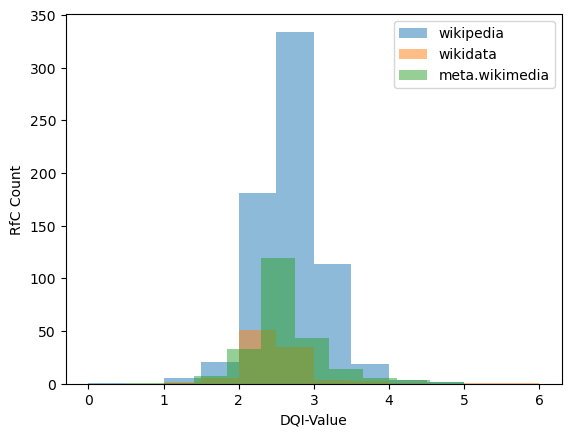

In [35]:
grouped = delib_rfc_df.groupby(['project', 'mean_dqi_value']).size().reset_index(name='count')

# Get a list of all projects
projects = delib_rfc_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['mean_dqi_value'], bins=10, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('DQI-Value')
plt.ylabel('RfC Count')
plt.legend()

# Show the plot
plt.show()

In [36]:
# Group the RFC DataFrame by project and calculate the mean of the dqi_value column
grouped_rfc_df = delib_rfc_df.groupby("project")["mean_dqi_value"].mean()

In [37]:
print(grouped_rfc_df)

project
meta.wikimedia    2.706543
wikidata          2.517597
wikipedia         2.645050
Name: mean_dqi_value, dtype: float64


In [38]:
# separate data by project
proj1 = delib_rfc_df.loc[rfc_df['project'] == 'wikipedia']['mean_dqi_value']
proj2 = delib_rfc_df.loc[rfc_df['project'] == 'wikidata']['mean_dqi_value']

# perform two-sample t-test
t_value, p_value = ttest_ind(proj1, proj2, equal_var=False)

# print results
print("Two-sample t-test results for wikipedia and wikidata:")
print("T-value: {:.4f}".format(t_value))
print("P-value: {:.4f}".format(p_value))

if p_value < 0.05:
    print("There is a significant difference between wikipedia and wikidata.")
else:
    print("There is no significant difference between wikipedia and wikidata.")

Two-sample t-test results for wikipedia and wikidata:
T-value: 2.3210
P-value: 0.0216
There is a significant difference between wikipedia and wikidata.


In [39]:
proj3 = delib_rfc_df.loc[delib_rfc_df['project'] == 'meta.wikimedia']['mean_dqi_value']
# perform two-sample t-test
t_value, p_value = ttest_ind(proj2, proj3, equal_var=False)

# print results
print("Two-sample t-test results for wikidata and meta:")
print("T-value: {:.4f}".format(t_value))
print("P-value: {:.4f}".format(p_value))

if p_value < 0.05:
    print("There is a significant difference between wikidata and meta.")
else:
    print("There is no significant difference between wikidata and meta.")

Two-sample t-test results for wikidata and meta:
T-value: -3.2098
P-value: 0.0015
There is a significant difference between wikidata and meta.


In [40]:
# perform two-sample t-test
t_value, p_value = ttest_ind(proj1, proj3, equal_var=False)

# print results
print("Two-sample t-test results for wikipedia and meta:")
print("T-value: {:.4f}".format(t_value))
print("P-value: {:.4f}".format(p_value))

if p_value < 0.05:
    print("There is a significant difference between wikipedia and meta.")
else:
    print("There is no significant difference between wikipedia and meta.")

Two-sample t-test results for wikipedia and meta:
T-value: -2.3179
P-value: 0.0207
There is a significant difference between wikipedia and meta.


In [41]:
'''
# calculate percentage of 1s for each column
percentages = (filtered_list.mean() * 100).round(2)

# print results
print(percentages)
'''

'\n# calculate percentage of 1s for each column\npercentages = (filtered_list.mean() * 100).round(2)\n\n# print results\nprint(percentages)\n'

In [42]:
# get the row where constructive_proposal is 1
constructive_row = deliberation_df.loc[deliberation_df['constructive_proposal'] == 1]

# print the row
print(constructive_row['text'][30])

@Jirka.h23: thanks for your patience. I'm not an everyday editor, and I won't be around much in November. If you took the time to read my response above I did give my analysis of existing proposals and gave two proposals of my own. If your fine with either of those than we can move forward from there since SF stated in reply to them Template:Tq is only for quoting in talk and project pages. Do not use it in actual articles.Category:Pages with incorrect formatting templates use, if not then submit your own proposal. It's also worth noting that the RFC has not yet expired and as close as the expiry is we should still still allow that new editors may see it and also want to join in. In addition, some of the other editors I pinged in my first comment have also yet to edit again and it would be polite to give them a little longer too, remember there is no deadline.I see this going two ways; either after giving everyone reasonable time to weigh back in, say a week or so, an existing proposal

# Support,Oppose,Comment,Neutral

In [43]:
def detect_sentiment(text):
    words = text.lower().split()[:5]
    if any(word.startswith("support") for word in words):
        return "support"
    elif any(word.startswith("oppose") for word in words):
        return "oppose"
    elif any(word.startswith("comment") for word in words):
        return "comment"
    elif any(word.startswith("neutral") for word in words):
        return "neutral"
    else:
        return "unknown"

In [44]:
check_for_stance_df = comment_df
# preprocess the comment text column
check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')

/tmp/ipykernel_12511/1606589629.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  check_for_stance_df['text'] = check_for_stance_df['text'].str.lower().str.replace('[^\w\s]', '')


In [45]:
comment_df['sentiment'] = check_for_stance_df['text'].apply(detect_sentiment)

In [46]:
# group the comments by RFC and count the number of True values in the support and oppose columns
sentiment_counts = comment_df.groupby(['rfc_id','sentiment'])['sentiment'].size().unstack(fill_value = 0)

In [47]:
sentiment_df = rfc_df.merge(sentiment_counts, on='rfc_id')

In [48]:
sentiment_df['support_ratio'] = sentiment_df['support'] / (sentiment_df['support'] + sentiment_df['oppose'])

In [49]:
sentiment_df['support_ratio'].fillna(0, inplace=True)

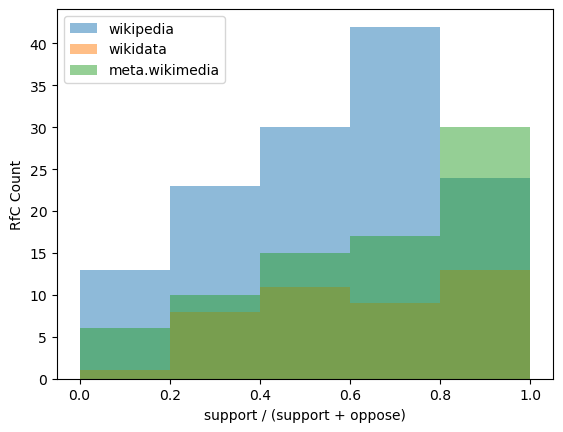

In [50]:
grouped = sentiment_df.groupby(['project', 'support_ratio']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['support_ratio'], bins=5,alpha=0.5, label=project, width = 0.2)

# Add axis labels and a legend
plt.xlabel('support / (support + oppose)')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

In [51]:
grouped.head()

,project,support_ratio,count
0,meta.wikimedia,0.000000,338
1,meta.wikimedia,0.117512,1
2,meta.wikimedia,0.117783,1
3,meta.wikimedia,0.128205,2
4,meta.wikimedia,0.142857,2


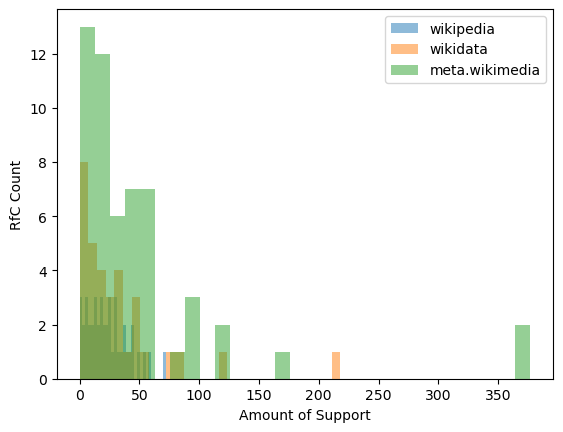

In [52]:
grouped = sentiment_df.groupby(['project', 'support']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['support'], bins=30,alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Amount of Support')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

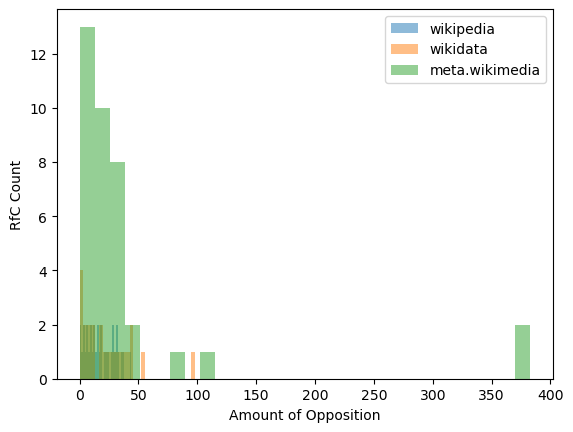

In [53]:
grouped = sentiment_df.groupby(['project', 'oppose']).size().reset_index(name='count')

# Get a list of all projects
projects = sentiment_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['oppose'], bins=30,alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('Amount of Opposition')
plt.ylabel('RfC Count')
plt.legend()
# Show the plot
plt.show()

In [54]:
grouped.head()

,project,oppose,count
0,meta.wikimedia,0,392
1,meta.wikimedia,1,46
2,meta.wikimedia,2,18
3,meta.wikimedia,3,14
4,meta.wikimedia,4,16


/tmp/ipykernel_12511/1471649611.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for project, group in grouped:


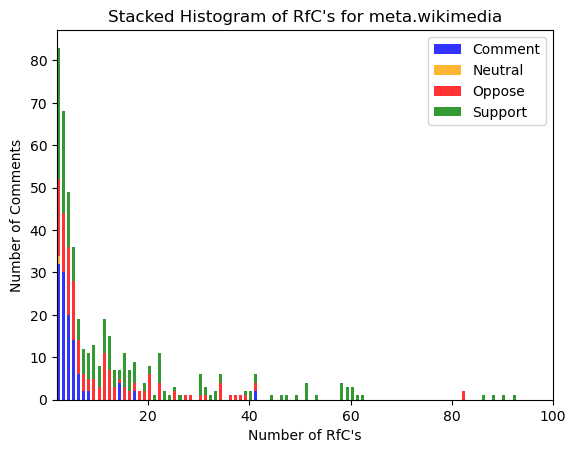

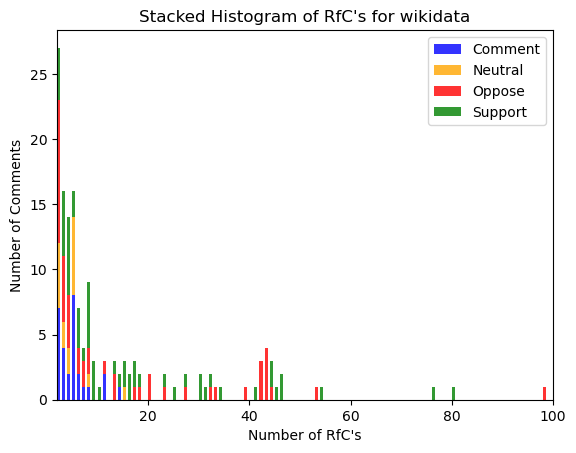

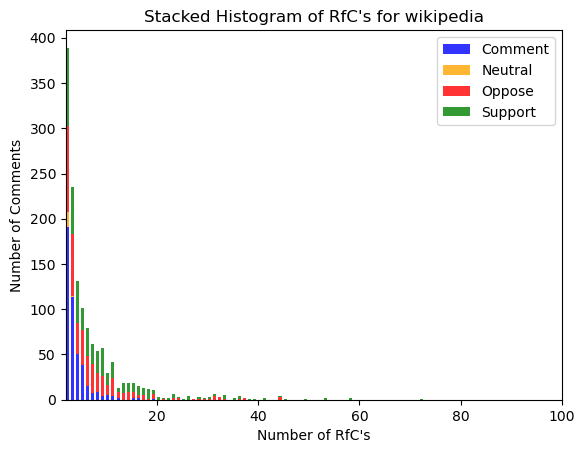

In [55]:
# merge comment dataframe with RFC dataframe
grouped = sentiment_df.groupby(['project'])

# Create a separate histogram for each project
for project, group in grouped:

    # Create a list of values for the stacked bars
    stacked_data = [
        group['comment'].values,
        group['neutral'].values,
        group['oppose'].values,
        group['support'].values,
    ]

    # Set the colors of the bars
    colors = ['b', 'orange', 'r', 'g']

    # Create a stacked histogram
    plt.hist(stacked_data, bins=range(2, len(group) + 2), stacked=True, alpha=0.8, color=colors, label=['Comment', 'Neutral', 'Oppose', 'Support'], width=0.6)

    # Set the title, x-axis label, and y-axis label
    plt.title(f'Stacked Histogram of RfC\'s for {project}')
    plt.xlabel('Number of RfC\'s')
    plt.ylabel('Number of Comments')
    # Set the range of the x-axis
    plt.xlim([2, 100])
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

## How long are discussion active?

In [65]:
rfc_df = pd.read_csv('../data/rfc.csv')
comment_df = pd.read_csv('../data/rfc_comments.csv')
user_json = "../data/json_files/user_info/users.json"
with open(user_json) as f:
    users = json.load(f)
users_df = pd.DataFrame(users)

In [66]:
#fixing different date formats
from dateutil.parser import parse
# define a function to parse date strings using dateutil.parser
def parse_date(date_str):
    try:
        date = re.search(r'\d{2}:\d{2}, \d{1,2} \w+ \d{4} \(UTC\)', str(date_str))
        if date:
            # parse the input string into a datetime object
            input_datetime = datetime.strptime(date.group(), "%H:%M, %d %B %Y (%Z)")

            # format the datetime object in the desired output format
            return input_datetime.strftime("%Y-%m-%dT%H:%M:%SZ")
        else:
            return parse(date_str)
    except:
        return pd.NaT

# apply the parse_date function to the "date" column
comment_df['date'] = comment_df['date'].apply(parse_date)
# apply the parse_date function to the "date" column
rfc_df['closing_date'] = rfc_df['closing_date'].apply(parse_date)

# check the result
print(comment_df['date'])

0       2020-10-06 13:22:00+00:00
1       2020-10-07 06:22:00+00:00
2       2020-10-06 16:03:00+00:00
3       2020-10-06 16:27:00+00:00
4       2020-10-06 18:15:00+00:00
                   ...           
92249   2023-02-11 11:18:00+00:00
92250   2023-02-09 23:02:00+00:00
92251   2023-02-11 18:49:00+00:00
92252   2023-02-11 19:39:00+00:00
92253   2023-02-24 02:55:00+00:00
Name: date, Length: 92254, dtype: datetime64[ns, tzutc()]


In [67]:
rfc_df['closing_date'] = pd.to_datetime(rfc_df['closing_date'], utc=True)

In [68]:
# join the two dataframes based on the "id" and "discussion_input_comment" columns
merged_df = pd.merge(comment_df[['id', 'date']], rfc_df[['rfc_id', 'closing_date', 'discussion_input_comment','project']], left_on='id', right_on='discussion_input_comment')
# subtract datetime column from array of datetime values
merged_df['time_delta'] = merged_df['closing_date'] - merged_df['date']

In [69]:
# group the data by 'project' and calculate the mean of 'time_delta' for each group
avg_time = merged_df.groupby('project')['time_delta'].mean()

# print the average time for each project
print(avg_time)

project
meta.wikimedia   347 days 18:33:42.303370788
wikidata            315 days 19:45:37.500000
wikipedia         40 days 07:02:26.386010362
Name: time_delta, dtype: timedelta64[ns]


In [70]:
merged_df['time_delta'] = merged_df['time_delta'].dt.days

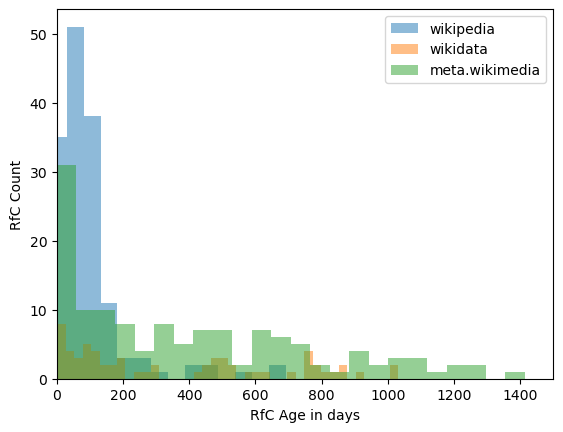

In [71]:
grouped = merged_df.groupby(['project', 'time_delta']).size().reset_index(name='count')

# Get a list of all projects
projects = merged_df['project'].unique()

# Plot a histogram for each project
for project in projects:
    # Get the subset of data for this project
    subset = grouped[grouped['project'] == project]
    
    # Plot the histogram
    plt.hist(subset['time_delta'], bins=40, alpha=0.5, label=project)

# Add axis labels and a legend
plt.xlabel('RfC Age in days')
plt.ylabel('RfC Count')
plt.legend()
plt.xlim([0, 1500])
# Show the plot
plt.show()

###  To what extent does the participants’ diversity influence the resolution of the deliberation?

In [72]:
# merge the entropy values with the original dataframe
merged_df1 = pd.merge(delib_rfc_df, merged_df, on='rfc_id')
merged_df = pd.merge(merged_df1, entropy, on='rfc_id')

In [73]:
merged_df.head()

,page_id,rfc_id,page_title,discussion_input_comment_x,project_x,closing_date_x,mean_dqi_value,id,date,closing_date_y,discussion_input_comment_y,project_y,time_delta,entropy
0,29488,0,Talk:Skyscraper,0,wikipedia,2021-01-05T06:57:00Z,3.696970,0,2020-10-06 13:22:00+00:00,2021-01-05 06:57:00+00:00,0,wikipedia,90.0,1.891909
1,22415346,1,Talk:Bell Media Radio,35,wikipedia,2019-12-18T03:35:00Z,3.333333,35,2019-10-09 15:43:00+00:00,2019-12-18 03:35:00+00:00,35,wikipedia,69.0,0.918296
2,55480246,2,Talk:Noah Kraft,38,wikipedia,2019-10-11T09:04:00Z,2.730769,38,2019-09-05 17:34:00+00:00,2019-10-11 09:04:00+00:00,38,wikipedia,35.0,2.848941
3,55480246,3,Talk:Noah Kraft,64,wikipedia,2019-10-11T09:04:00Z,2.730769,64,2019-09-05 17:34:00+00:00,2019-10-11 09:04:00+00:00,64,wikipedia,35.0,2.848941
4,66698580,4,Wikipedia:Reliable sources/Noticeboard/Archive...,90,wikipedia,2021-02-03T21:13:00Z,2.577778,90,2020-05-24 11:55:00+00:00,2021-02-03 21:13:00+00:00,90,wikipedia,255.0,3.143759


In [74]:
# group the data by project class
grouped = merged_df.groupby('project_x')

In [75]:
# loop through each group and calculate the correlation between time_delta and entropy
for name, group in grouped:
    correlation = group['time_delta'].corr(merged_df['entropy'])
    print(f"Correlation for class {name}: {correlation}")

Correlation for class meta.wikimedia: 0.05967529648383268
Correlation for class wikidata: -0.2061484113257241
Correlation for class wikipedia: 0.035870949128427254


In [76]:
# loop through each group and calculate the correlation between time_delta and deliberation
for name, group in grouped:
    correlation = group['time_delta'].corr(group['mean_dqi_value'])
    print(f"Correlation for class {name}: {correlation}")

Correlation for class meta.wikimedia: 0.17585199466893625
Correlation for class wikidata: -0.008107802321198442
Correlation for class wikipedia: -0.0018495927785997718


## Text Comparison

In [77]:
grouped = comment_df.groupby('project')
# create a dictionary of dataframes, with one dataframe for each unique value in the "class" column
dfs = {name: group for name, group in grouped}

# access each dataframe using its corresponding key
df_wikipedia_text = dfs['wikipedia']['text'].tolist()
df_wikidata_text = dfs['wikidata']['text'].tolist()
df_meta_text = dfs['meta.wikimedia']['text'].tolist()
# download the stopwords data if you haven't already
nltk.download('stopwords')

# get the set of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/dylan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
def remove_punctuation(txt):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

def clean_text(txt):
    """Removes punctuation, changes to lowercase, removes
        stopwords, removes "animal" and "crossing", and
        calculates word frequencies.

    Parameters
    ----------
    txt : string
        A text string that you want to clean.

    Returns
    -------
    Words and frequencies
    """

    tmp = [remove_punctuation(t) for t in txt]
    tmp = [t.lower().split() for t in tmp]

    tmp = [[w for w in t if not w in stop_words]
                for t in tmp]
    tmp = [[w for w in t if not w in ['animal', 'crossing']]
                        for t in tmp]

    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return tmp

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


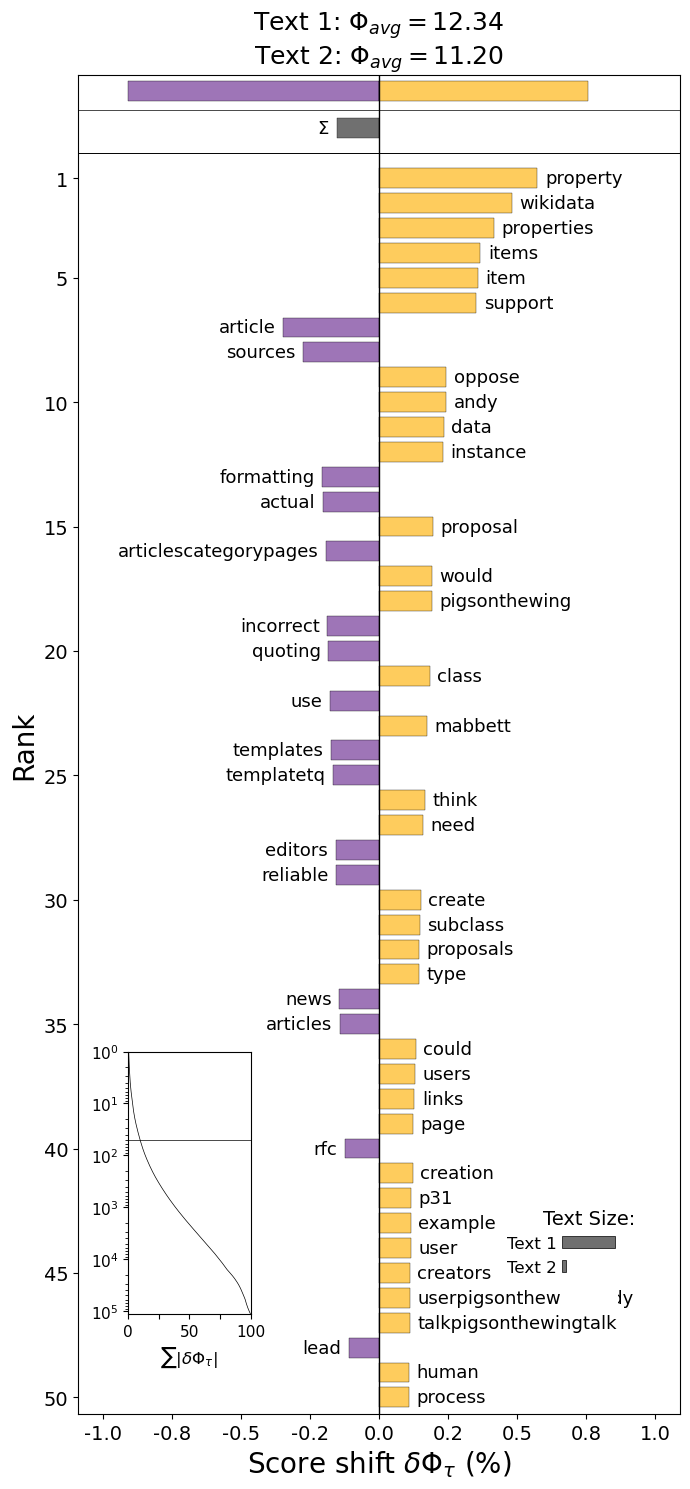

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.34\nText 2: $\\Phi_{avg}=$11.20'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [79]:
clean_texts_wikipedia = clean_text(df_wikipedia_text)
clean_texts_wikidata = clean_text(df_wikidata_text)
clean_texts_meta = clean_text(df_meta_text)
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_wikidata, base = 2)
entropy_shift.get_shift_graph() 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


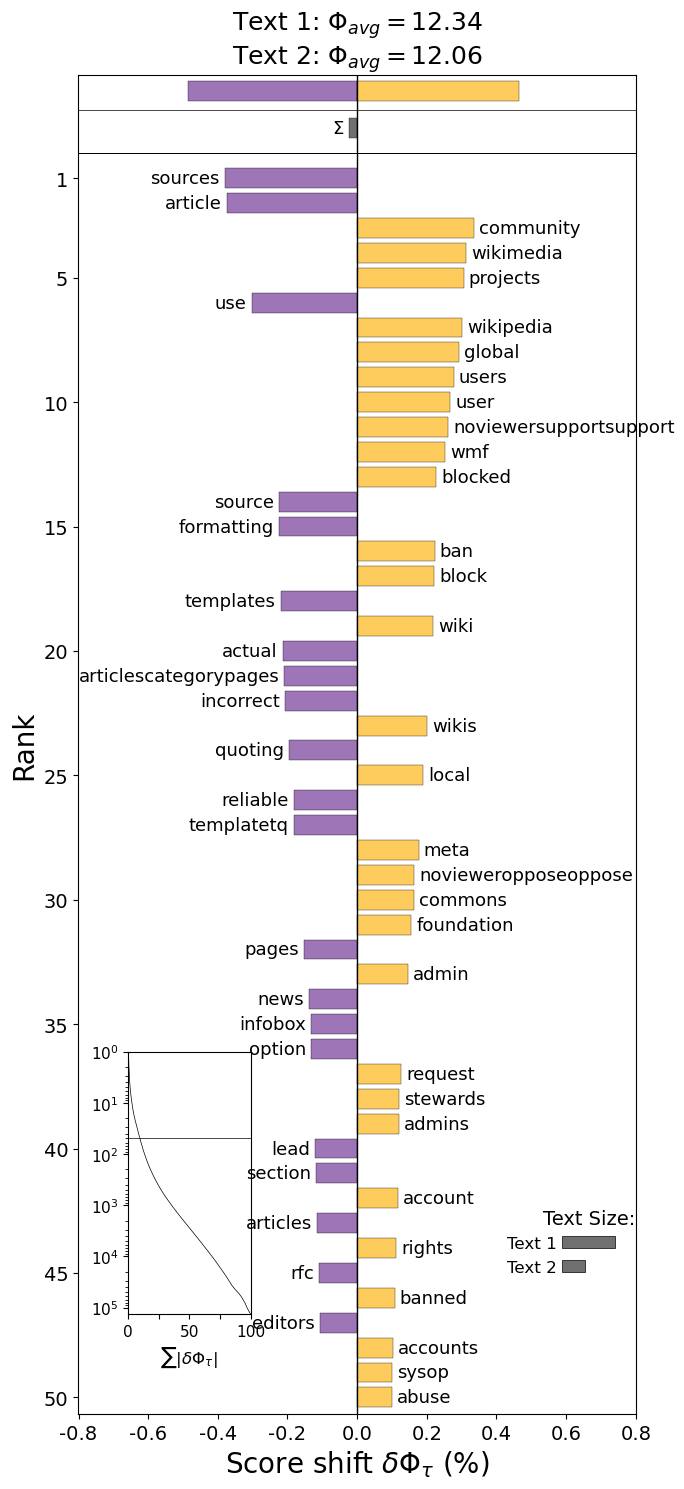

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$12.34\nText 2: $\\Phi_{avg}=$12.06'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [80]:
entropy_shift = shifts.EntropyShift(clean_texts_wikipedia, clean_texts_meta, base = 2)
entropy_shift.get_shift_graph() 

/home/dylan/anaconda3/envs/test_env/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


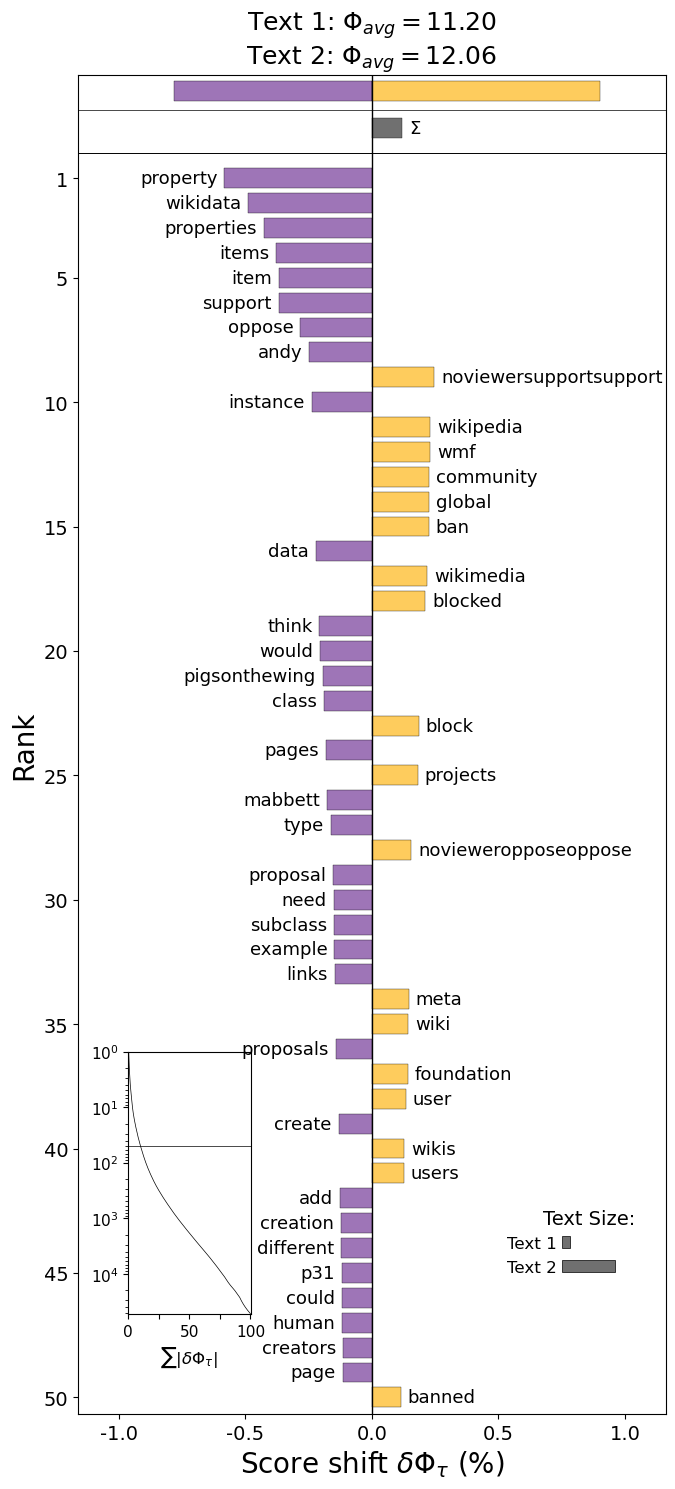

<Axes: title={'center': 'Text 1: $\\Phi_{avg}=$11.20\nText 2: $\\Phi_{avg}=$12.06'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [81]:
entropy_shift = shifts.EntropyShift(clean_texts_wikidata, clean_texts_meta, base = 2)
entropy_shift.get_shift_graph() 